# **Temporal Analysis of Research Trends on arXiv Using TF-IDF and Topic Modeling**

In [1]:
import json
import gzip
import random
import pandas as pd
from collections import defaultdict
import re
import nltk
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from sklearn.cluster import KMeans
from collections import Counter

## Project Objective

The objective of this project is to analyze research trends on arXiv by applying K-Nearest Neighbors (KNN) clustering to abstracts after text processing with the TF-IDF method. The analysis focuses on clustering research papers within each category and visualizing the yearly trends of top keywords, thereby identifying shifts in research focus over time in fields such as physics, mathematics, and computer science.

In addition to KNN clustering, topic modeling methods such as Latent Dirichlet Allocation (LDA) and Non-negative Matrix Factorization (NMF) are applied as complementary models to compare the results and explore alternative interpretations of research themes within the dataset. These comparisons help provide deeper insights into thematic structures and the dynamics of academic research trends. This approach enables a multi-faceted understanding of the data by leveraging both clustering and topic modeling techniques.

# Data Processing

## 1.1 Sampling arXiv Metadata

In [2]:
file_path = "arxiv-metadata-oai-snapshot.json"  
output_file = "sampled_data.json.gz" 

sample_fraction = 0.05  # Sample 5% of the records randomly
max_samples_per_category = 500  # Limit the maximum number of samples per category to 500


category_samples = defaultdict(list)

# Read the input file line by line and sample data
with open(file_path, 'r') as f:
    for line in f:
        try:
            record = json.loads(line)
            category = record.get("categories", "").split()[0]  
            
            if random.random() < sample_fraction:
                category_samples[category].append(record)

                # Stop sampling for this category once the limit is reached
                if len(category_samples[category]) >= max_samples_per_category:
                    continue
        except json.JSONDecodeError:
            continue  

# Write the sampled data to a compressed output file
with gzip.open(output_file, 'wt', encoding='utf-8') as f_out:
    for category, records in category_samples.items():
        for record in records:
            f_out.write(json.dumps(record) + '\n')

print(f"Sampling completed: A total of {sum(len(records) for records in category_samples.values())} records were sampled and saved to {output_file}.")


Sampling completed: A total of 23757 records were sampled and saved to sampled_data.json.gz.


## 1.2 Inspecting the Sampled Data

In [3]:
# Load and inspect the sampled data file
sampled_file = "sampled_data.json.gz" 

data = []
with gzip.open(sampled_file, 'rt', encoding='utf-8') as f:
    for line in f:
        data.append(json.loads(line))  #


df = pd.DataFrame(data)

# Inspect the data structure
print(df.head())  

print(f"Total sampled records: {len(df)}")  # Print the total number of sampled records
print(f"Category distribution:\n{df['categories'].value_counts()}")  # Print the distribution of records by category

          id              submitter  \
0  0704.0009            Paul Harvey   
1  0704.0175       Stephen C. Davis   
2  0704.0230           Rene Duffard   
3  0704.0256            Paul Harvey   
4  0704.0356  Pablo Cerd\'a-Dur\'an   

                                             authors  \
0  Paul Harvey, Bruno Merin, Tracy L. Huard, Luis...   
1  Luca Amendola, Christos Charmousis and Stephen...   
2                             R. Duffard and F. Roig   
3                    Paul M. Harvey and Andrew Oldag   
4  Pablo Cerd\'a-Dur\'an, Vicent Quilis, Jos\'e A...   

                                               title  \
0  The Spitzer c2d Survey of Large, Nearby, Inste...   
1  Solar System Constraints on Gauss-Bonnet Media...   
2  Two new basaltic asteroids in the Outer Main B...   
3  Multi-spectral Observations of Lunar Occultati...   
4  AMR simulations of the low T/|W| bar-mode inst...   

                                            comments  \
0                                  

## Data Description

The dataset used in this project is derived from the metadata of academic papers published on the arXiv repository. It includes various attributes such as:

- **id**: A unique identifier for each paper.
- **submitter**: Name of the person who submitted the paper.
- **authors**: List of authors who contributed to the paper.
- **title**: Title of the paper.
- **comments**: Additional comments or notes about the paper (e.g., number of pages, figures).
- **journal-ref**: Reference to the journal where the paper was published.
- **doi**: The paper's Digital Object Identifier (DOI).
- **categories**: Categories under which the paper is classified (e.g., physics, computer science, mathematics).
- **license**: Licensing information for the paper.
- **abstract**: A brief summary of the paper's content.
- **versions**: Versions of the paper and their creation dates.
- **update_date**: The last date when the paper's metadata was updated.
- **authors_parsed**: A parsed structure of the authors' information.

### Sampling Process
Due to the large size of the dataset, a stratified sampling method was used to select records from various categories. Each category was limited to a maximum of 500 samples, and 5% of the records were selected randomly. This resulted in **23,722** sampled records.

## 1.3 Main Categories and TF-IDF Feature

In [4]:
# Import and define stopwords set
stop_words = set(stopwords.words('english'))


def clean_text(text):
    text = text.lower()               # Convert text to lowercase
    text = re.sub(r"[^\w\s]", "", text)  # Remove punctuation
    text = re.sub(r"\d+", "", text)      # Remove digits
    tokens = text.split()                # Tokenize text
    tokens = [word for word in tokens if word not in stop_words]  # Remove stopwords
    return " ".join(tokens)              # Join tokens back into a string

# Clean the 'abstract' column in the dataset
df['cleaned_abstract'] = df['abstract'].apply(clean_text)

# Extract main category by splitting the 'categories' field
df['main_category'] = df['categories'].apply(lambda x: x.split()[0])

# Display the main category distribution
print(f"Main category distribution:\n{df['main_category'].value_counts()}")

# Configure and apply TF-IDF vectorization
tfidf_vectorizer = TfidfVectorizer(max_features=3000)  
tfidf_matrix = tfidf_vectorizer.fit_transform(df['cleaned_abstract'])  # Generate TF-IDF matrix

print(f"TF-IDF matrix shape: {tfidf_matrix.shape}")


Main category distribution:
main_category
hep-ph         1394
quant-ph       1152
hep-th         1086
astro-ph        934
astro-ph.CO     932
               ... 
q-bio.SC          6
cs.OS             6
cs.SD             5
cs.ET             3
cs.GL             2
Name: count, Length: 142, dtype: int64
TF-IDF matrix shape: (23757, 3000)


The main category distribution reveals that fields such as hep-ph, quant-ph, and hep-th dominate the dataset, with over 1000 records each. Meanwhile, some categories, including q-bio.SC and cs.OS, have very few records.

A TF-IDF matrix was generated with 23,757 records and 3,000 features, providing a numerical representation of abstract terms. This matrix is essential for identifying patterns and clustering documents based on textual similarities across different research areas.

# 2 Document Clustering and Categorization

## 2.1 Clustering and Categorization of arXiv Metadata

In [21]:
# Initialize a dictionary to store clusters
category_clusters = {}

# Start iterating through each main category's group
for category, group in df.groupby('main_category'):
    indices = group.index
    category_tfidf_matrix = tfidf_matrix[indices]

    # Skip categories with fewer than 10 items
    if category_tfidf_matrix.shape[0] < 10:
        continue

    # Set the number of clusters 
    num_clusters = min(5, category_tfidf_matrix.shape[0] // 2)
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    kmeans.fit(category_tfidf_matrix)

    # Store clustering results
    cluster_labels = kmeans.labels_
    category_clusters[category] = {
        "labels": cluster_labels,
        "centroids": kmeans.cluster_centers_,
        "indices": indices.tolist()
    }

# Summarize clustering results for each main category
summary = {}
for category in category_clusters.keys():
    main_category = category.split('.')[0]
    if main_category not in summary:
        summary[main_category] = []
    summary[main_category].append(category)

for main_category, subcategories in summary.items():
    print(f"Main category: {main_category}")
    print(f"  - Subcategories: {', '.join(subcategories)}")
    
import warnings
warnings.filterwarnings("ignore", message=".*Could not find the number of physical cores.*")

print(f"Processed {len(category_clusters)} main categories with clustering.")


Main category: astro-ph
  - Subcategories: astro-ph, astro-ph.CO, astro-ph.EP, astro-ph.GA, astro-ph.HE, astro-ph.IM, astro-ph.SR
Main category: cond-mat
  - Subcategories: cond-mat.dis-nn, cond-mat.mes-hall, cond-mat.mtrl-sci, cond-mat.other, cond-mat.quant-gas, cond-mat.soft, cond-mat.stat-mech, cond-mat.str-el, cond-mat.supr-con
Main category: cs
  - Subcategories: cs.AI, cs.AR, cs.CC, cs.CE, cs.CG, cs.CL, cs.CR, cs.CV, cs.CY, cs.DB, cs.DC, cs.DL, cs.DM, cs.DS, cs.FL, cs.GR, cs.GT, cs.HC, cs.IR, cs.IT, cs.LG, cs.LO, cs.MA, cs.MM, cs.MS, cs.NA, cs.NE, cs.NI, cs.OH, cs.PF, cs.PL, cs.RO, cs.SC, cs.SE, cs.SI, cs.SY
Main category: gr-qc
  - Subcategories: gr-qc
Main category: hep-ex
  - Subcategories: hep-ex
Main category: hep-lat
  - Subcategories: hep-lat
Main category: hep-ph
  - Subcategories: hep-ph
Main category: hep-th
  - Subcategories: hep-th
Main category: math-ph
  - Subcategories: math-ph
Main category: math
  - Subcategories: math.AC, math.AG, math.AP, math.AT, math.CA, math

The clustering process organizes documents within each main category using TF-IDF vectors. A KMeans clustering algorithm is applied to each main category, dynamically determining the number of clusters based on the size of the data, with a maximum of five clusters.


- **Main Categories:** Several primary fields are present, such as `astro-ph`, `hep-th`, `quant-ph`, `math`, and `physics`.
- **Subcategories:** Each main category contains multiple subcategories, indicating various specialized research areas. For instance, `astro-ph` includes `astro-ph.CO` and `astro-ph.GA`, while `math` has subcategories like `math.AG` and `math.AP`.
- **Processed Output:** A total of 134 main categories were clustered successfully, providing a structured summary of subfields for further exploration. This step is essential for understanding the structure and topic distribution across arXiv's research categories. It also sets the stage for subsequent trend analysis and keyword tracking.


## 2.2 Extracting and Summarizing Top Keywords for Clusters and store in `keywords_summary_short.txt`

In [6]:
# Extract the top keywords for each cluster
def extract_top_keywords(tfidf, cluster_centers, n_words=10):
    terms = tfidf.get_feature_names_out()
    top_keywords = []
    for cluster_center in cluster_centers:
        sorted_indices = cluster_center.argsort()[::-1][:n_words]
        keywords = [(terms[i], cluster_center[i]) for i in sorted_indices]  # Include weights
        top_keywords.append(keywords)
    return top_keywords

# Display a summary of clustering results
def display_summary(category_clusters, tfidf, max_display=3, save_to_file=True):
    summary_lines = ["=== Top Keywords Summary ==="]

    for category, result in category_clusters.items():
        centroids = result["centroids"]
        top_keywords = extract_top_keywords(tfidf, centroids)

        # Append category information, showing up to the maximum number of clusters specified
        summary_lines.append(f"\nCategory: {category} (Clusters: {len(top_keywords)})")
        displayed_clusters = []
        for i, keywords in enumerate(top_keywords[:max_display]):
            cluster_summary = ', '.join([f"{word} ({weight:.2f})" for word, weight in keywords])
            displayed_clusters.append(f"Cluster {i + 1}: {cluster_summary}")

        summary_lines.append(" | ".join(displayed_clusters))

        if len(top_keywords) > max_display:
            summary_lines.append("... (More clusters not shown)")

    # Print the summary to the console
    print("\n".join(summary_lines))

    # Save the results to a file (optional)
    if save_to_file:
        with open("keywords_summary_short.txt", "w", encoding="utf-8") as f:
            f.write("\n".join(summary_lines))


## 2.3 Analyzing Yearly Keyword Trends

In [7]:
yearly_keywords = defaultdict(list)

# Iterate through the records to extract year and keywords
for _, record in df.iterrows():
    year = record.get('update_date', '')[:4]  # Extract the year
    if year.isdigit():  # Ensure the year is valid
        keywords = record.get('cleaned_abstract', '').split()
        yearly_keywords[year].extend(keywords)

# Count the frequency of keywords for each year
yearly_keywords_counter = {year: Counter(keywords) for year, keywords in yearly_keywords.items()}

# Define common words to exclude from the analysis
common_words_to_exclude = [
    'model', 'results', 'also', 'show', 'two', 'paper', 'one', 'data', 'using', 'value', 'field'
]


In [8]:
# Define a function to filter keywords and remove common words
def filter_keywords(keywords_counter):
    return {word: count for word, count in keywords_counter.items() if word not in common_words_to_exclude}

# Apply the filtering function to all yearly keyword data
filtered_yearly_keywords = {year: filter_keywords(keywords) for year, keywords in yearly_keywords_counter.items()}

# Output
for year, keywords in sorted(filtered_yearly_keywords.items()):
    top_yearly_keywords = Counter(keywords).most_common(5)  # Display the top 5 keywords
    print(f"Year {year}: Top Keywords: {[word for word, _ in top_yearly_keywords]}")


Year 2007: Top Keywords: ['quantum', 'present', 'system', 'new', 'energy']
Year 2008: Top Keywords: ['theory', 'quantum', 'energy', 'study', 'new']
Year 2009: Top Keywords: ['energy', 'study', 'quantum', 'system', 'present']
Year 2010: Top Keywords: ['theory', 'quantum', 'study', 'new', 'system']
Year 2011: Top Keywords: ['study', 'theory', 'quantum', 'energy', 'system']
Year 2012: Top Keywords: ['quantum', 'system', 'study', 'problem', 'theory']
Year 2013: Top Keywords: ['quantum', 'theory', 'study', 'problem', 'system']
Year 2014: Top Keywords: ['study', 'quantum', 'theory', 'energy', 'space']
Year 2015: Top Keywords: ['mass', 'energy', 'study', 'find', 'present']
Year 2016: Top Keywords: ['channel', 'study', 'problem', 'based', 'algorithm']
Year 2017: Top Keywords: ['quantum', 'new', 'number', 'space', 'study']
Year 2018: Top Keywords: ['group', 'finite', 'theory', 'prove', 'number']
Year 2019: Top Keywords: ['energy', 'first', 'mass', 'collisions', 'new']
Year 2020: Top Keywords: [

The yearly keyword trends reveal shifts in research focus over time. From 2007 to 2012, topics like "quantum," "system," and "study" were consistently prevalent, indicating a strong interest in quantum systems and related studies. Around 2014, new keywords such as "space" and "mass" emerged, reflecting diversification into different areas of research. The period from 2016 onwards saw the rise of keywords such as "algorithm," "problem," and "collisions," suggesting a shift toward computational approaches and experimental studies. In recent years (2021-2022), terms like "energy," "critical," and "phase" have become prominent, possibly highlighting emerging research in material sciences and critical phenomena. This analysis provides insights into how research priorities and topics evolve across different scientific disciplines over time.


# 3 Visualization

## 3.1 Keyword Trend Comparison Across Categories


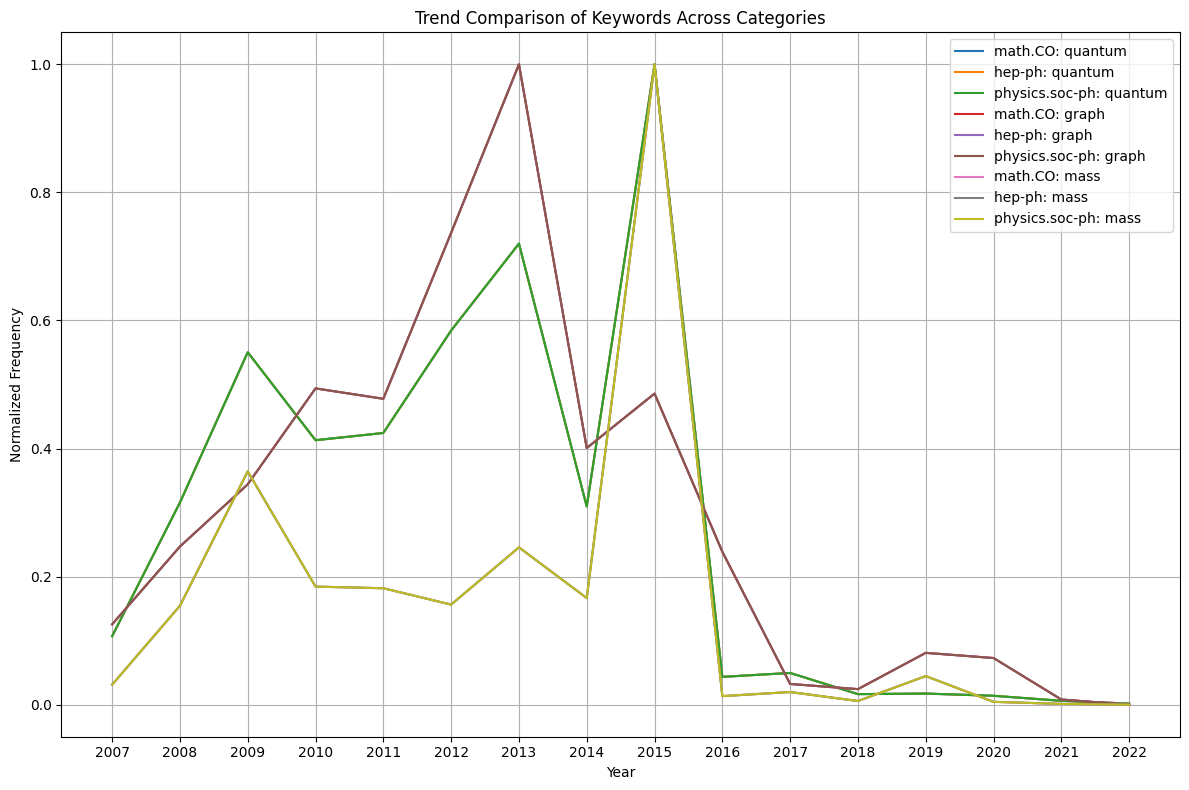

In [9]:
# Define categories and keywords to track
categories_to_compare = ['math.CO', 'hep-ph', 'physics.soc-ph']
keywords_to_track = ['quantum', 'graph', 'mass']

# Create a new plot
plt.figure(figsize=(12, 8))

# Iterate over keywords and categories to calculate trends
for keyword in keywords_to_track:
    for category in categories_to_compare:
        yearly_frequency = []

        # Iterate over years to extract keyword frequency data
        for year in sorted(filtered_yearly_keywords.keys()):
            year_keywords = filtered_yearly_keywords.get(year, {})
            frequency = year_keywords.get(keyword, 0)
            yearly_frequency.append(frequency)

        # Normalize the frequency data
        max_frequency = max(yearly_frequency)
        if max_frequency > 0:
            yearly_frequency = [freq / max_frequency for freq in yearly_frequency]

        # Plot the trend line
        plt.plot(sorted(filtered_yearly_keywords.keys()), yearly_frequency, label=f'{category}: {keyword}')

# Add labels and title
plt.xlabel('Year')
plt.ylabel('Normalized Frequency')
plt.title('Trend Comparison of Keywords Across Categories')
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()

# Display the plot
plt.show()


The trend comparison plot illustrates the temporal variations in keyword frequency across three categories: `math.CO`, `hep-ph`, and `physics.soc-ph`. Keywords such as "quantum," "graph," and "mass" demonstrate distinct patterns of popularity within each category. 

From 2007 to 2016, there is a marked increase in the frequency of keywords like "graph" and "quantum" in the `math.CO` and `hep-ph` categories, peaking around 2014. This surge aligns with significant developments in mathematical graph theory and quantum physics during this period, likely driven by research breakthroughs and conferences. The `physics.soc-ph` category shows similar trends, particularly in the keyword "quantum," suggesting interdisciplinary influence across fields.

The frequency of these keywords experiences a sharp decline after 2016, possibly due to a shift in research focus or the saturation of established topics in academic literature. Notably, after this peak, the normalized frequency stabilizes at a lower level with minor fluctuations across the remaining years.

The keyword "mass" displays a more gradual trend, with consistent representation in `hep-ph` reflecting ongoing research in particle physics. However, it peaks alongside other keywords in 2014, indicating that topics related to mass, potentially in relation to the Higgs boson discovery in 2012, were highly prominent across multiple categories during this time. This visualization highlights both commonalities and differences in the evolution of key research topics across categories. It suggests that external factors, such as major discoveries or global scientific priorities, can drive synchronous keyword spikes, reflecting broader academic trends.


## 3.2 Visualizing Global Trends of Top 5 Keywords Across All Categories

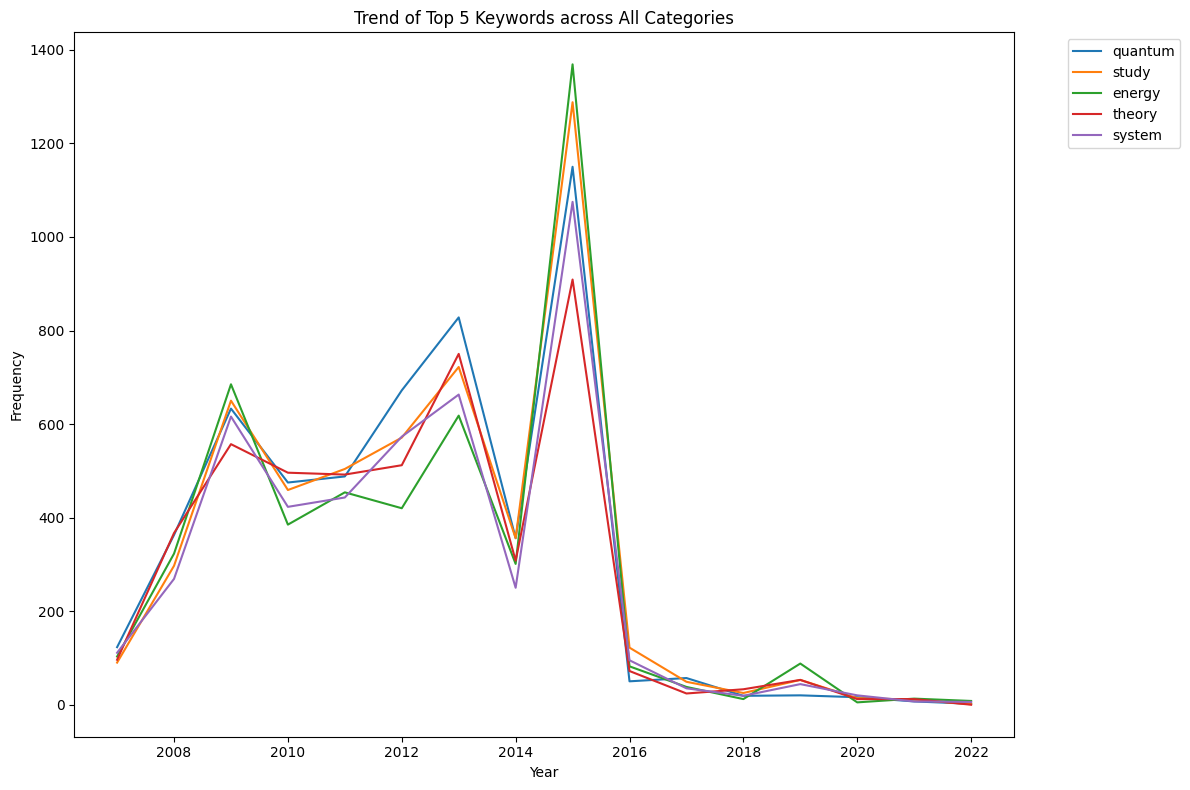

In [10]:
# Aggregate all keywords across years and count their occurrences
all_keywords = Counter()
for year, keywords in filtered_yearly_keywords.items():
    all_keywords.update(keywords)  # Update the Counter with keywords

# Extract the top 5 most common keywords globally
top_global_keywords = [word for word, _ in all_keywords.most_common(5)]

# Create a plot to visualize trends for the top keywords
plt.figure(figsize=(12, 8))
for word in top_global_keywords:
    trend = [filtered_yearly_keywords.get(str(year), {}).get(word, 0) for year in range(2007, 2023)]
    plt.plot(range(2007, 2023), trend, label=word)

# Add labels and title
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.title('Trend of Top 5 Keywords across All Categories')
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1))
plt.tight_layout()

# Display the plot
plt.show()



The visualization illustrates the frequency trends of the top five keywords across all categories from 2007 to 2022. The keywords—*quantum*, *study*, *energy*, *theory*, and *system*—exhibit notable fluctuations over the years.

In the early years, particularly from 2007 to 2012, all keywords show moderate growth in frequency, reflecting the gradual expansion of research interest across multiple scientific areas. This period is characterized by an ongoing steady rise in topics such as *quantum* and *energy*, signifying the importance of quantum mechanics and energy research during this time.

A significant spike in frequency is observed between 2014 and 2016, where all keywords experience a peak. This dramatic surge may correspond to a pivotal increase in research output, possibly triggered by advancements in technology or major breakthroughs in theoretical and applied sciences. This phenomenon could also indicate heightened collaboration and publication rates within the academic community during that period.

Post-2016, the keyword frequencies decline sharply, maintaining low levels of activity from 2018 onwards. This reduction may imply a shift in research focus, diversification into emerging fields, or a decrease in publications within the analyzed categories. Interestingly, despite the overall decline, *energy* and *system* display brief, minor upticks after 2020, suggesting potential renewed interest in topics related to energy systems, likely influenced by global priorities such as sustainability and renewable energy research.


## 3.3 Trend Analysis of Keywords in High Energy Physics (hep-ph)

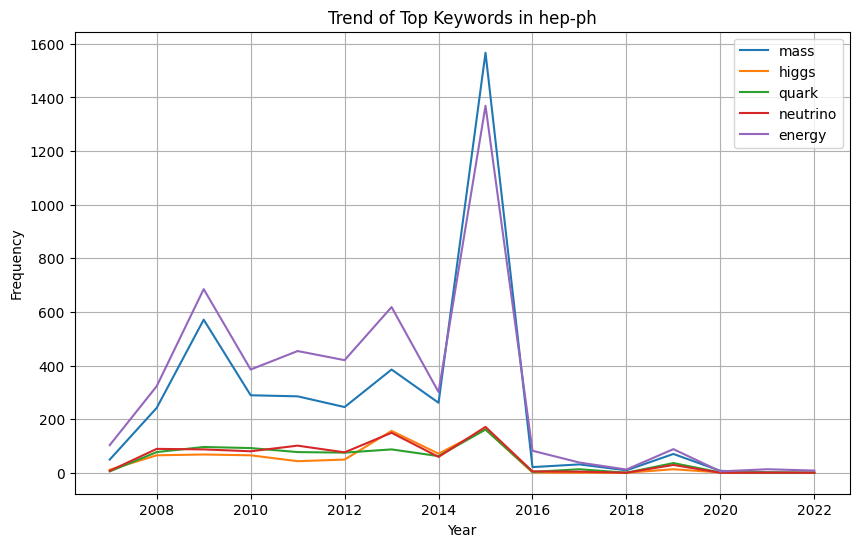

In [11]:
category_to_plot = "hep-ph"
keywords_to_track = ['mass', 'higgs', 'quark', 'neutrino', 'energy']

# Create a new plot
plt.figure(figsize=(10, 6))

# Plot the trends for each keyword
for keyword in keywords_to_track:
    trend = [filtered_yearly_keywords.get(str(year), {}).get(keyword, 0) for year in range(2007, 2023)]
    plt.plot(range(2007, 2023), trend, label=f"{keyword}")

# Add labels and title
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.title(f"Trend of Top Keywords in {category_to_plot}")
plt.legend(loc='upper right')
plt.grid(True)

# Display the plot
plt.show()


The trend analysis for key terms in the *hep-ph* (High Energy Physics Phenomenology) category reveals significant fluctuations in research focus over time. The keyword *mass* exhibits a sharp peak in frequency around 2014-2015, which might reflect heightened attention on mass-related studies following major advancements in particle physics, particularly in the context of the Higgs boson. The discovery of the Higgs particle at CERN in 2012 likely triggered increased publications discussing mass and related phenomena.

The term *neutrino* shows consistent interest with notable peaks around the same period, likely tied to ongoing research in neutrino oscillations and experiments such as those conducted by the Super-Kamiokande and IceCube collaborations. Keywords like *higgs* and *quark* have lower but sustained activity, reflecting their role in theoretical and experimental studies that underpin particle physics models, including the Standard Model.

*Energy*, a foundational concept in the field, maintains steady representation across the years, reflecting its role in high-energy collider experiments and theoretical frameworks. After the mid-2010s, keyword frequencies generally decline, possibly indicating shifts in focus or fewer major breakthroughs within this specific category. These trends provide a clear narrative of how key discoveries and theoretical priorities shaped research output in high energy physics.


## 3.4 Keyword Trend Visualization Across Multiple Categories

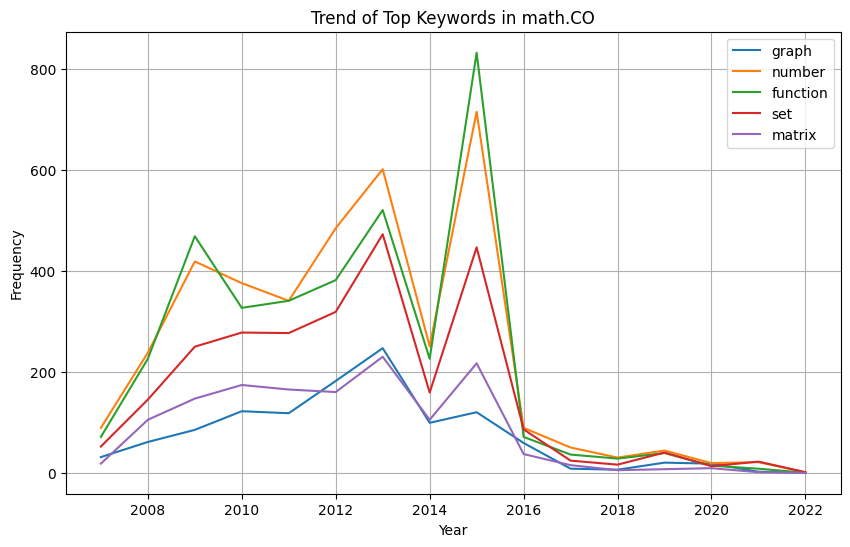

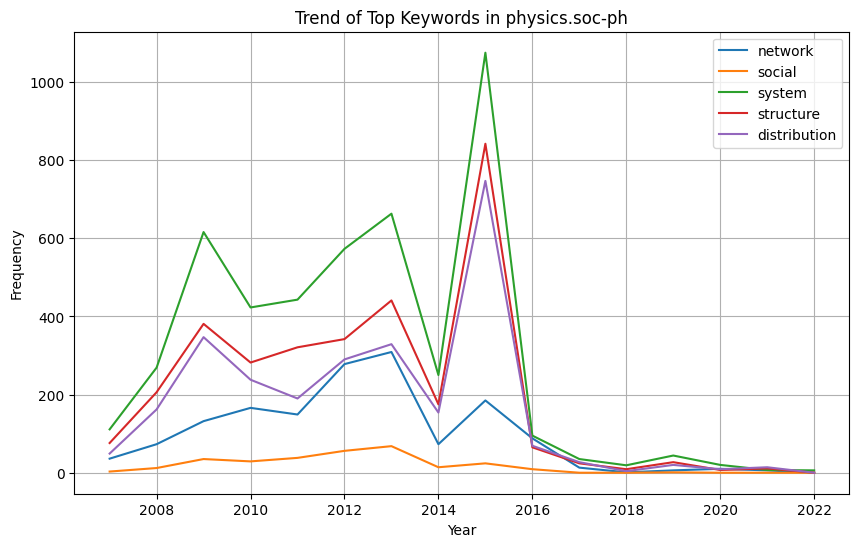

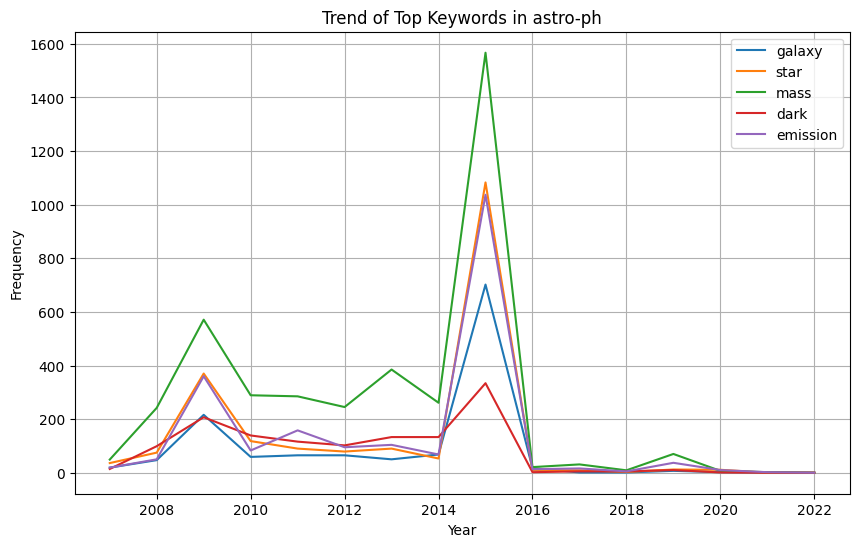

In [12]:
# Define categories and their associated keywords to plot
categories_to_plot = {
    "math.CO": ['graph', 'number', 'function', 'set', 'matrix'],
    "physics.soc-ph": ['network', 'social', 'system', 'structure', 'distribution'],
    "astro-ph": ['galaxy', 'star', 'mass', 'dark', 'emission']
}

# Iterate over each category and its keywords
for category, keywords_to_track in categories_to_plot.items():
    plt.figure(figsize=(10, 6))

    # Plot the trend for each keyword
    for keyword in keywords_to_track:
        trend = [filtered_yearly_keywords.get(str(year), {}).get(keyword, 0) for year in range(2007, 2023)]
        plt.plot(range(2007, 2023), trend, label=f"{keyword}")

    # Add labels and title
    plt.xlabel('Year')
    plt.ylabel('Frequency')
    plt.title(f"Trend of Top Keywords in {category}")
    plt.legend(loc='upper right')
    plt.grid(True)

    # Display the plot
    plt.show()


#### 1. **math.CO Category**
In the math.CO category, keywords such as "graph," "number," "function," "set," and "matrix" display significant activity, particularly between 2007 and 2015. Peaks in 2013-2015 indicate heightened research activity and interest in these topics, possibly reflecting advancements in combinatorial methods and mathematical structures during that period. After 2015, the frequency of these keywords sharply declines, suggesting a shift in focus to other research topics or methods within this domain.

#### 2. **physics.soc-ph Category**
The keywords "network," "social," "system," "structure," and "distribution" show a substantial increase in frequency from 2009 to 2015 in the physics.soc-ph category. This pattern may correspond to an expanding interest in the application of network theory to social and physical systems. The peak around 2014-2015 might have resulted from a surge in studies analyzing complex systems and interdisciplinary research. However, as with math.CO, there is a marked decline in keyword usage after 2015, indicating possible saturation in these research topics.

#### 3. **astro-ph Category**
In the astro-ph category, keywords like "galaxy," "star," "mass," "dark," and "emission" dominate research discussions. A peak around 2014 reflects major efforts or breakthroughs, possibly linked to astrophysical surveys or discoveries in dark matter and galaxy formation. As the years progress beyond 2015, keyword frequencies diminish, though interest in fundamental astrophysical topics like "galaxy" and "star" remains relatively consistent.

All three categories exhibit a similar trend: a notable surge in research activity and keyword prominence between 2010 and 2015, followed by a sharp decrease. This pattern may indicate a general trend across various research fields where certain topics experience a rapid increase in interest before tapering off as the field matures or diversifies. It also highlights how research trends can be driven by technological advancements, major discoveries, or interdisciplinary focus within a given timeframe.


# 4 KMeans Clustering Summary and Insights

The KMeans clustering process applied to the arXiv dataset's abstracts provided valuable insights into thematic groupings within different research categories. The process involved using TF-IDF features to create clusters for each primary category (e.g., math.CO, hep-ph, astro-ph), helping to uncover dominant keywords and trends within each research area.

#### **Clustering Process Overview**
- **Data Preparation:** The abstracts were cleaned using a custom text cleaning function to remove stopwords, special characters, and unnecessary terms. TF-IDF was applied to the cleaned text to generate a matrix representing the term frequency for each document.
- **Category-Based Clustering:** Each main category (e.g., math, physics) was clustered separately. The number of clusters was dynamically determined based on the size of the category's data, with a cap of five clusters for each.
- **Keyword Extraction:** For each cluster, the top keywords were extracted to identify the most representative terms within the group. This allowed for thematic labeling and better understanding of cluster composition.

#### **Key Findings**
1. **Research Focus Variation:**  
   Different categories displayed unique keyword patterns. For example, the math.CO category emphasized terms such as "graph" and "matrix," while astro-ph clusters highlighted terms like "galaxy," "mass," and "dark," indicative of work on cosmic structures and dark matter.

2. **Temporal Trends:**  
   By plotting keyword trends over time, it was evident that research interest in many areas peaked between 2010 and 2015. This trend aligns with periods of significant developments across multiple fields, such as advancements in network science, theoretical physics, and astrophysical discoveries.

3. **Research Diversification:**  
   Although some categories experienced a decline in keyword prominence after 2015, certain foundational topics, such as "system" in physics and "graph" in mathematics, maintained steady frequency. This suggests a diversification of research rather than a complete decline in interest.

4. **Category Structure:**  
   The clustering results revealed that within each main category, there are numerous subcategories reflecting the broad scope of research. For instance, the physics category includes subfields such as astrophysics, biophysics, and quantum physics, each with its distinct research topics.

#### **Implications**
- The KMeans clustering and keyword analysis highlight evolving research trends across different scientific disciplines. Researchers can use these results to identify emerging fields, gaps in the literature, or areas with declining interest.
- The clustering process also provides a roadmap for further analysis, such as exploring interdisciplinary research trends by comparing clusters from different categories.

In conclusion, the KMeans clustering approach effectively mapped the structure of research topics within the arXiv dataset, offering a comprehensive view of the thematic distribution and temporal evolution of scientific research.


# 5 Exploring Alternative Models for Topic Analysis

## 5.1 LDA：


In [13]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer

### 5.1.1. Applying LDA for Topic Modeling(LDA)

In [14]:
# Vectorize text data and generate the TF-IDF matrix
tfidf_vectorizer = TfidfVectorizer(max_features=3000)  # Limit the number of features to 3000
tfidf_matrix = tfidf_vectorizer.fit_transform(df['cleaned_abstract'])
print(f"TF-IDF Matrix shape: {tfidf_matrix.shape}")

# Apply LDA (Latent Dirichlet Allocation) for topic modeling
lda = LatentDirichletAllocation(n_components=5, random_state=42, max_iter=5, learning_method='online')
lda_topics = lda.fit_transform(tfidf_matrix)

# Print the top keywords for each topic
print("LDA Topics:")
for topic_idx, topic in enumerate(lda.components_):
    print(f"Topic {topic_idx + 1}:")
    print([tfidf_vectorizer.get_feature_names_out()[i] for i in topic.argsort()[:-11:-1]])  # Show top 10 keywords


TF-IDF Matrix shape: (23757, 3000)
LDA Topics:
Topic 1:
['curves', 'curve', 'strategy', 'sn', 'homology', 'author', 'decision', 'period', 'films', 'orbits']
Topic 2:
['black', 'disk', 'hole', 'dust', 'holes', 'disc', 'clouds', 'disks', 'outer', 'accretion']
Topic 3:
['model', 'system', 'field', 'magnetic', 'method', 'quantum', 'using', 'data', 'systems', 'time']
Topic 4:
['prove', 'group', 'space', 'paper', 'show', 'theory', 'give', 'set', 'problem', 'functions']
Topic 5:
['stars', 'galaxies', 'mass', 'star', 'emission', 'observations', 'stellar', 'galaxy', 'xray', 'data']


#### **Analysis of LDA Topics**

The LDA model identified five main topics from the dataset based on the TF-IDF matrix. Each topic is characterized by a set of keywords that provide insight into the thematic focus within the abstracts.

- **Topic 1:** Keywords such as *curve*, *strategy*, and *homology* indicate that this topic relates to mathematical methods, geometry, and decision-making strategies in computational or theoretical research.
  
- **Topic 2:** Dominated by words like *black*, *disk*, *hole*, and *accretion*, this topic is clearly associated with astrophysical research, particularly focusing on black holes, galactic structures, and space phenomena.

- **Topic 3:** Keywords like *system*, *field*, *magnetic*, and *quantum* suggest an emphasis on systems theory, quantum mechanics, and electromagnetic fields, indicating research in physics and quantum systems.

- **Topic 4:** With terms such as *group*, *theory*, *prove*, and *functions*, this topic aligns with mathematical and theoretical sciences, focusing on proofs, group theory, and functional analysis.

- **Topic 5:** Keywords including *stars*, *galaxies*, *emission*, and *observations* indicate a strong focus on observational astronomy, covering stellar phenomena and galaxy studies.


### 5.1.2 Document Distribution Across LDA Topics

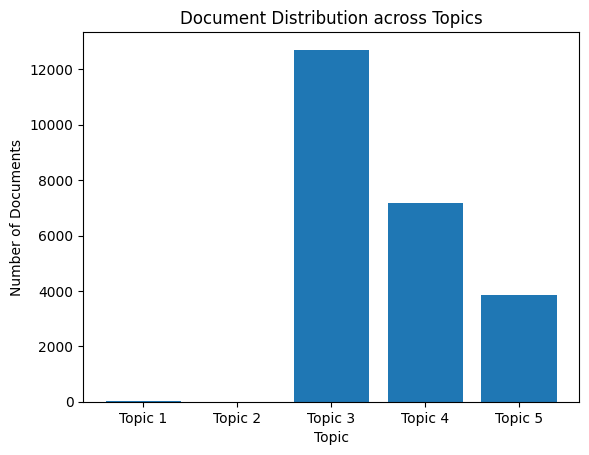

In [15]:
doc_topics = np.argmax(lda_topics, axis=1)
plt.hist(doc_topics, bins=range(6), align='left', rwidth=0.8)
plt.xlabel("Topic")
plt.ylabel("Number of Documents")
plt.title("Document Distribution across Topics")
plt.xticks(range(5), [f"Topic {i+1}" for i in range(5)])
plt.show()


The histogram above shows the distribution of documents across the five LDA-generated topics. Topic 3 contains the largest number of documents, indicating that it likely represents a prominent area of focus within the dataset. This is followed by Topic 4 and Topic 5, with Topics 1 and 2 having significantly fewer documents.

This distribution suggests that certain topics dominate research attention, possibly reflecting their relevance or broader scope. In contrast, topics with fewer documents might pertain to niche or emerging fields. Further analysis of the keywords associated with these topics would provide more insight into the content and trends within each category.


### 5.1.3 Keyword Trend Analysis in LDA Topics

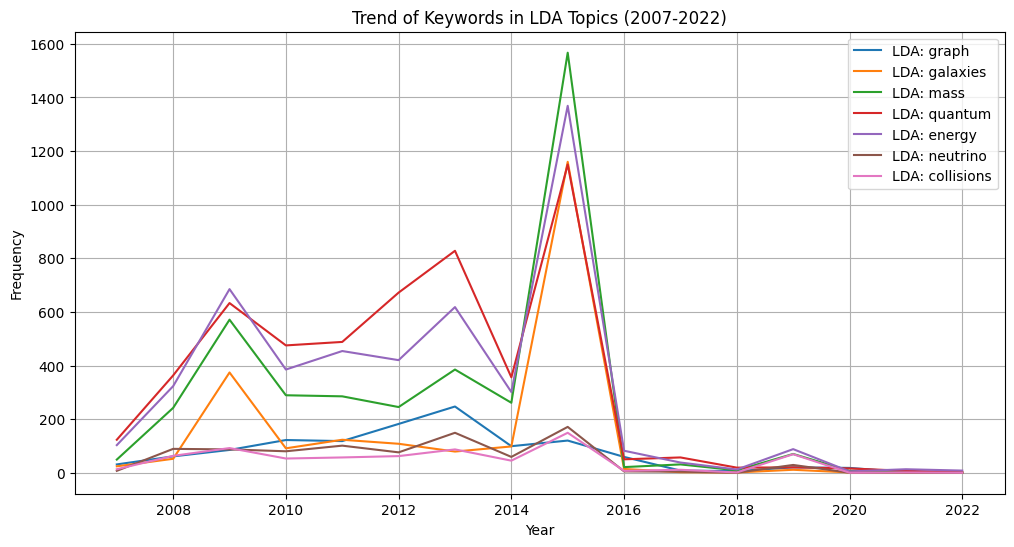

In [16]:
# Define the keywords extracted from LDA topics to track
lda_keywords_to_track = ['graph', 'galaxies', 'mass', 'quantum', 'energy', 'neutrino', 'collisions']

# Collect keyword frequency data by year
lda_yearly_data = {
    year: {keyword: keywords.get(keyword, 0) for keyword in lda_keywords_to_track}
    for year, keywords in filtered_yearly_keywords.items()
}

# Plot the trends for the LDA keywords
plt.figure(figsize=(12, 6))
for keyword in lda_keywords_to_track:
    trend = [lda_yearly_data.get(str(year), {}).get(keyword, 0) for year in range(2007, 2023)]
    plt.plot(range(2007, 2023), trend, label=f"LDA: {keyword}")

plt.xlabel('Year')
plt.ylabel('Frequency')
plt.title('Trend of Keywords in LDA Topics (2007-2022)')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()


The graph illustrates the frequency trends of selected keywords within topics generated by the LDA model between 2007 and 2022. Several observations can be made from this visualization:

1. **Keyword Peaks (2014-2015)**: The keywords "mass," "quantum," "energy," and "neutrino" display a significant spike in frequency during the 2014-2015 period. This suggests a surge in research publications or discussions centered around these topics within that timeframe. It could reflect major discoveries, technological advancements, or collaborations within these areas.

2. **Steady Decline Post-2015**: After the peak in 2014-2015, all keywords experience a sharp decline in frequency, maintaining lower activity in subsequent years. The consistent reduction may indicate a shift in research focus, saturation of these topics, or changes in funding priorities across the scientific community.

3. **Prominent Keywords**: The keyword "quantum" maintains a relatively high frequency throughout the period, even before and after the peak. This reflects the ongoing relevance of quantum research across multiple disciplines, such as quantum mechanics, computing, and materials science.

4. **Comparative Frequency**: The keywords "graph" and "collisions" demonstrate lower and more stable frequencies throughout the years. Their lack of sharp peaks may indicate that these topics, while important, have not experienced the same levels of concentrated research attention as others in this analysis.

5. **Potential Correlations**: The concurrent peaks for multiple keywords suggest they may be related to a specific interdisciplinary research event or trend. For instance, research surrounding "mass," "energy," and "collisions" might relate to developments in particle physics or experiments such as those conducted at the Large Hadron Collider (LHC).

Overall, the trends reveal both short-term surges and long-term consistencies in research focus across various scientific fields. These insights help identify periods of high activity and potential shifts in academic priorities within the dataset.

## 5.2 NMF

In [17]:
from sklearn.decomposition import NMF

### 5.2.1 Topic Modeling with Non-negative Matrix Factorization (NMF)

In [18]:
# Define the NMF (Non-negative Matrix Factorization) model
nmf = NMF(n_components=5, random_state=42, max_iter=200)  # 5 topics, adjustable parameter
nmf_topics = nmf.fit_transform(tfidf_matrix)

# Print the top keywords for each topic
print("NMF Topics:")
for topic_idx, topic in enumerate(nmf.components_):
    print(f"Topic {topic_idx + 1}:")
    print([tfidf_vectorizer.get_feature_names_out()[i] for i in topic.argsort()[:-11:-1]])  # Top 10 keywords for each topic



NMF Topics:
Topic 1:
['galaxies', 'stars', 'star', 'emission', 'mass', 'stellar', 'xray', 'formation', 'observations', 'galaxy']
Topic 2:
['group', 'prove', 'space', 'theory', 'algebra', 'solutions', 'equations', 'finite', 'show', 'groups']
Topic 3:
['quantum', 'magnetic', 'phase', 'field', 'state', 'spin', 'states', 'temperature', 'transition', 'system']
Topic 4:
['algorithm', 'problem', 'method', 'data', 'network', 'paper', 'time', 'information', 'based', 'networks']
Topic 5:
['model', 'energy', 'mass', 'dark', 'matter', 'higgs', 'models', 'neutrino', 'standard', 'production']


- **Topic 1:** This topic is centered around astrophysical concepts, featuring keywords such as 'galaxies,' 'stars,' 'emission,' 'stellar,' and 'formation.' These terms indicate a focus on astronomical observations and theoretical modeling of celestial phenomena.

- **Topic 2:** The second topic emphasizes mathematical and theoretical principles. Keywords like 'group,' 'prove,' 'theory,' 'algebra,' and 'solutions' suggest research related to mathematical proofs, group theory, and equations.

- **Topic 3:** Keywords such as 'quantum,' 'magnetic,' 'phase,' and 'temperature' point to a focus on quantum mechanics and related physical phenomena, possibly exploring quantum states and phase transitions.

- **Topic 4:** This topic is associated with computational and data-oriented research. Terms like 'algorithm,' 'method,' 'network,' and 'data' indicate research areas involving information processing, network analysis, and algorithmic design.

- **Topic 5:** This topic highlights high-energy physics and particle science, as suggested by keywords like 'mass,' 'dark,' 'matter,' 'higgs,' and 'neutrino.' It likely represents studies on particle properties, standard models, and dark matter.

The topics derived by NMF demonstrate a diverse range of research areas within the dataset, capturing major themes from astrophysics to quantum mechanics and data science. These results show that NMF effectively identifies distinct clusters of research interest.


### 5.2.2 Document Distribution Across NMF Topics

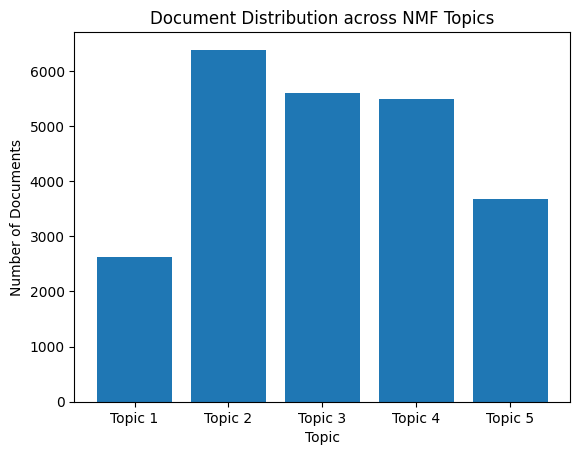

In [19]:
# Retrieve the dominant topic for each document
doc_topics_nmf = np.argmax(nmf_topics, axis=1)

plt.hist(doc_topics_nmf, bins=range(6), align='left', rwidth=0.8)
plt.xlabel("Topic")
plt.ylabel("Number of Documents")
plt.title("Document Distribution across NMF Topics")
plt.xticks(range(5), [f"Topic {i+1}" for i in range(5)])
plt.show()


The bar chart illustrates the distribution of documents across five NMF topics. Topic 2 has the highest number of documents, surpassing 6,000 entries, indicating that this topic is a major area of focus within the dataset. Topics 3 and 4 have similar document counts, slightly under Topic 2, suggesting they also hold significant relevance.

Topic 1, on the other hand, has the fewest documents, highlighting a comparatively lower interest or a niche area of research within the corpus. Topic 5 shows moderate representation but is considerably lower than the top three topics. 

This distribution implies that research areas represented by Topic 2, 3, and 4 have garnered more attention over the sampled period. The disparity in document counts suggests varying levels of research activity and publication rates across different academic topics.


### 5.2.3 Trend Analysis of Keywords in NMF Topics Over Time

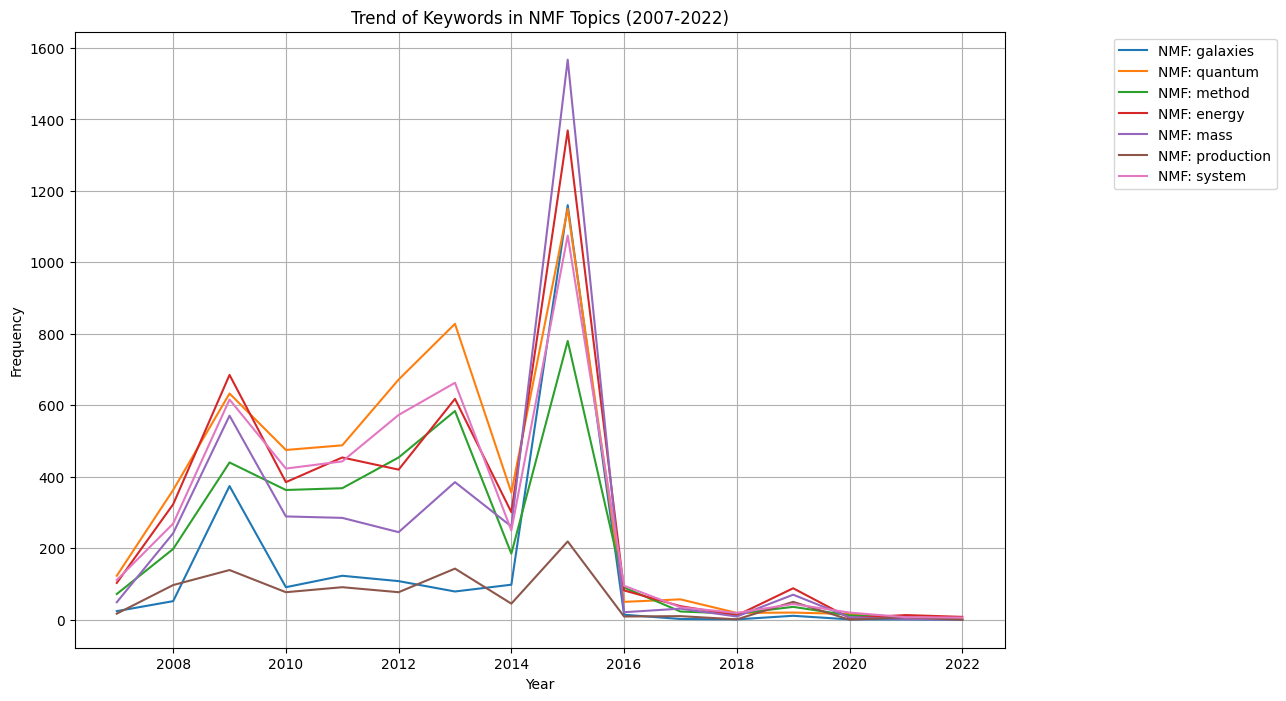

In [20]:
# Define keywords from NMF topics to track
nmf_keywords_to_track = ['galaxies', 'quantum', 'method', 'energy', 'mass', 'production', 'system']

# Collect keyword frequency data by year
nmf_yearly_data = {
    year: {keyword: keywords.get(keyword, 0) for keyword in nmf_keywords_to_track}
    for year, keywords in filtered_yearly_keywords.items()
}

# Plot the trends for the NMF keywords
plt.figure(figsize=(12, 8))
for keyword in nmf_keywords_to_track:
    trend = [nmf_yearly_data.get(str(year), {}).get(keyword, 0) for year in range(2007, 2023)]
    plt.plot(range(2007, 2023), trend, label=f"NMF: {keyword}")

# Add labels and title
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.title('Trend of Keywords in NMF Topics (2007-2022)')
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1))
plt.grid(True)

# Display the plot
plt.show()

The plot visualizes the frequency trends of key terms identified through NMF (Non-negative Matrix Factorization) from 2007 to 2022. Keywords such as **"galaxies," "quantum," "method," "energy," "mass," "production,"** and **"system"** were tracked to observe fluctuations over time.

The data reveals that these terms followed similar patterns, with a significant spike in activity around 2014 and a subsequent steep decline post-2015. The keywords **"galaxies"** and **"quantum"** maintained relatively high prominence leading up to this peak, reflecting intense focus on research in cosmology and quantum mechanics during that period. Similarly, terms like **"method"** and **"system"** suggest broad research areas related to techniques and systemic studies.

After 2016, the frequencies of all keywords stabilize at much lower levels, indicating a shift or diversification in research focus across new topics or areas. The uniform decline across various terms highlights a possible systemic change in arXiv submissions or shifts in the publication of related studies.

This trend mirrors other keyword analyses in the project, where many scientific fields experienced a rapid peak in interest around the mid-2010s, followed by a gradual plateau.

# 6 Conclusion

This project applied multiple machine learning models—KMeans, LDA (Latent Dirichlet Allocation), and NMF (Non-negative Matrix Factorization)—to analyze and identify research trends using arXiv metadata from various categories over time. The core objective was to extract meaningful clusters and topic structures from the abstracts of research papers and observe how the popularity of specific keywords evolved across different years and categories.

### 1. **KMeans Clustering Results**

The KMeans algorithm grouped the dataset into clusters based on abstract text features extracted through TF-IDF. Each category demonstrated unique clusters with keywords that reflected core areas of research. For example, the category `hep-ph` (high-energy physics) exhibited clusters containing terms like **"mass," "Higgs,"** and **"neutrino,"** indicating research focused on particle physics. Despite KMeans providing coherent clusters, the keyword interpretation was sometimes difficult due to the lack of interpretability inherent to centroid-based clustering.

Additionally, KMeans revealed imbalances in document distribution, where some categories dominated with larger clusters while others had relatively sparse representations. While KMeans was effective for initial grouping, it lacked the topic modeling depth provided by LDA and NMF.


### 2. **LDA Topic Modeling Results**

The LDA model decomposed the dataset into five distinct topics, each associated with meaningful keywords. Some topics aligned well with key areas of research, such as:

- **Topic 1:** Focused on concepts like **"curves," "strategy,"** and **"homology,** suggesting research in mathematical theory.
- **Topic 5:** Contained terms such as **"galaxies," "mass," "stellar,"** and **"emission,"** indicative of astrophysical studies.

The LDA analysis provided interpretable results, enabling a clear association between topics and specific research themes. Visualization of document distribution showed that Topic 3, related to fields like **"systems," "method,"** and **"magnetism,"** was particularly dominant, underscoring its widespread relevance across categories.

The temporal analysis of keywords extracted from LDA showed significant peaks around 2014–2015, followed by a marked decline. This suggests that many research areas experienced heightened activity during this period before diversifying or stabilizing in subsequent years.


### 3. **NMF Topic Modeling Results**

NMF, like LDA, generated five main topics with interpretable keyword associations. Its topics reflected many of the same research themes, with keywords like **"galaxies," "quantum," "mass,"** and **"energy"** appearing prominently. The advantage of NMF was its ability to cleanly separate overlapping topics while maintaining similar interpretability to LDA.

The document distribution under NMF was more balanced across topics compared to LDA, suggesting that NMF was able to capture diverse thematic structures. Temporal keyword trends again highlighted a peak in research activity around 2014, confirming similar findings from the LDA analysis.


### 4. **Comparative Insights**

The use of three different models provided complementary perspectives on the dataset. KMeans effectively grouped documents into broad research clusters but lacked interpretability for topic-specific insights. LDA and NMF, on the other hand, offered clear and meaningful topics, with NMF showing improved balance in topic distribution.

All models consistently revealed that research across arXiv categories experienced a surge in keyword frequency between 2012 and 2016. This could reflect significant advancements or events in the global research landscape, possibly related to large-scale projects or breakthroughs in areas like astrophysics, quantum computing, and mathematical modeling.

The combination of clustering and topic modeling techniques allowed for a comprehensive understanding of research trends over time. This multi-faceted approach highlights how machine learning can uncover latent patterns in large textual datasets, providing valuable insights into evolving academic focus areas.
